In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing import image
from glob import glob
from skimage.transform import resize
from skimage.util import img_as_ubyte

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

File ‘charmander-tight.png’ already there; not retrieving.



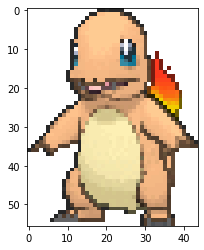

In [ ]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [ ]:
type(ch)

imageio.core.util.Array

In [ ]:
ch.shape

(56, 44, 4)

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

File ‘backgrounds.zip’ already there; not retrieving.



In [ ]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip


In [ ]:
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for background_file in background_files:
  bg = np.array(image.load_img(background_file))
  backgrounds.append(bg)

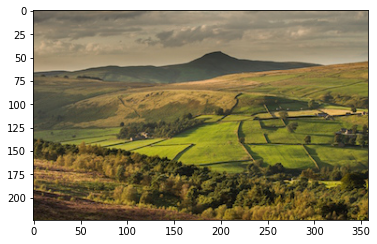

In [ ]:
plt.imshow(backgrounds[2])
plt.show()

In [ ]:
IMG_SIZE = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def image_generator_bg(batch_size=5):
  while True:
      X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # randomly select a background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_x = np.random.randint(bg_h - IMG_SIZE)
        rnd_y = np.random.randint(bg_w - IMG_SIZE)
        X[i] = bg[rnd_x:rnd_x+IMG_SIZE, rnd_y:rnd_y+IMG_SIZE].copy()

        # resize Charmander
        global ch
        scale = 0.5 + np.random.random()
        CH_H_new = int(CH_H * scale)
        CH_W_new = int(CH_W * scale)
        ch_new = img_as_ubyte(resize(ch, (CH_H_new, CH_W_new)))

        # flip Charmander with probability
        if np.random.random() < 0.5:
          ch_new = np.fliplr(ch_new)

        # locate a region for Charmander randomly
        row0 = np.random.randint(IMG_SIZE - CH_H_new)
        col0 = np.random.randint(IMG_SIZE - CH_W_new)
        row1 = row0 + CH_H_new
        col1 = col0 + CH_W_new

        # process Charmander and background so that we get the desired 
        # result when adding them together
        mask = (ch_new[:, :, 3] == 0) # find where the pokemon is 0
        bg_slice = X[i, row0:row1, col0:col1, :] # where we want to place pokemon
        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) * (h, w, 3)
        bg_slice += ch_new[:, :, :3] # "add" pokemon to the slice
        X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

        # make targets by normalization 
        Y[i, 0] = row0 / IMG_SIZE
        Y[i, 1] = col0 / IMG_SIZE
        Y[i, 2] = (row1 - row0) / IMG_SIZE
        Y[i, 3] = (col1 - col0) / IMG_SIZE

      yield X / 255.0, Y

In [ ]:
 X, _ = next(image_generator_bg())

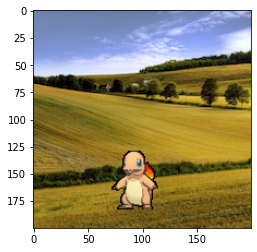

In [ ]:
plt.imshow(X[1])

In [ ]:
def make_model():
  vgg = tf.keras.applications.VGG16(
      input_shape=[IMG_SIZE, IMG_SIZE, 3], 
      include_top=False, 
      weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))

  return model

In [ ]:
model = make_model()
model.fit(
    image_generator_bg(),
    steps_per_epoch=100,
    epochs=8
)

Epoch 1/8
100/100 [==============================] - 9s 86ms/step - loss: 0.6723
Epoch 2/8
100/100 [==============================] - 9s 87ms/step - loss: 0.5966
Epoch 3/8
100/100 [==============================] - 9s 89ms/step - loss: 0.5715
Epoch 4/8
100/100 [==============================] - 9s 88ms/step - loss: 0.5604
Epoch 5/8
100/100 [==============================] - 9s 90ms/step - loss: 0.5513
Epoch 6/8
100/100 [==============================] - 9s 91ms/step - loss: 0.5477
Epoch 7/8
100/100 [==============================] - 9s 89ms/step - loss: 0.5411
Epoch 8/8
100/100 [==============================] - 9s 87ms/step - loss: 0.5479


In [ ]:
def pokemon_prediction_bg():
  # randomly select a background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_x = np.random.randint(bg_h - IMG_SIZE)
  rnd_y = np.random.randint(bg_w - IMG_SIZE)
  x = bg[rnd_x:rnd_x+IMG_SIZE, rnd_y:rnd_y+IMG_SIZE].copy()

  # resize Charmander
  global ch
  scale = 0.5 + np.random.random()
  CH_H_new = int(CH_H * scale)
  CH_W_new = int(CH_W * scale)
  ch_new = img_as_ubyte(resize(ch, (CH_H_new, CH_W_new)))

  # flip Charmander with probability
  if np.random.random() < 0.5:
    ch_new = np.fliplr(ch_new)

  # locate a region for Charmander randomly
  row0 = np.random.randint(IMG_SIZE - CH_H_new)
  col0 = np.random.randint(IMG_SIZE - CH_W_new)
  row1 = row0 + CH_H_new
  col1 = col0 + CH_W_new

  # process Charmander and background so that we get the desired 
  # result when adding them together
  mask = (ch_new[:, :, 3] == 0) # find where the pokemon is 0
  bg_slice = x[row0:row1, col0:col1, :] # where we want to place pokemon
  bg_slice = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) * (h, w, 3)
  bg_slice += ch_new[:, :, :3] # "add" pokemon to the slice
  x[row0:row1, col0:col1, :] = bg_slice # put the slice back

  print([row0, col0, row1, col1])

  # Predict
  X = np.expand_dims(x, 0) / 255.0
  p = model.predict(X)[0]
  print((p*IMG_SIZE).astype(int).tolist())
  
  # Draw the box
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
      p[3]*IMG_SIZE, 
      p[2]*IMG_SIZE, 
      linewidth=1, 
      edgecolor='r', 
      facecolor='none')
  ax.add_patch(rect)
  plt.show()

[0, 29, 44, 63]
[4, 24, 39, 33]


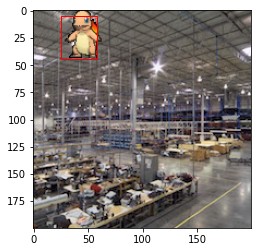

In [ ]:
pokemon_prediction_bg()